# Reflections on SXSW

A review of Apple's marketing and branding strategies at this year's South by Southwest Conference, to help the Apple marketing team plan next year's South by Southwest campaign.

**Author** &nbsp; Rebecca Neel

**Date** &nbsp; July 5, 2023

## Goals of the Analysis

To provide an overview of the brand's perception at this year's conference: what did people like, dislike and discuss the most? How was Apple perceived relative to its competitors?

- Build a classifier to "score" tweets as most negative, most positive and most neutral
- Determine the most negative and most positive SXSW tweets concerning Apple and its products
- Summarize the topics discussed in negative, neutral and positive tweets regarding Apple & its products


Ultimately, we hope to provide concrete recommendations for next year's SXSW brand & marketing strategy based on what was successful this year.

## Environment Set Up

Install packages and download stopwords from nltk.

In [1]:
%pip install xgboost

%pip install gensim

%pip install pyLDAvis

%pip install wordcloud

%pip install lime

%pip install imblearn

import nltk
nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 4.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 10.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 11.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 30.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 17.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3
ERROR: pip's dependenc

  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283839 sha256=2062bad5d2c82c1819c884bbc13a0916c5c028b230ff5f1ec1a0bce91c0d58c4
  Stored in directory: /home/ec2-user/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 18.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Make a list of package versions used in this environment.

In [4]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import nltk
import pyLDAvis
import gensim
import xgboost
import wordcloud
import lime
import imblearn
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pyLDAvis==3.4.0
sklearn==1.2.2
pandas==2.0.1
numpy==1.24.3
seaborn==0.11.2
nltk==3.8.1
gensim==4.3.1
xgboost==1.7.4
wordcloud==1.9.2
imblearn==0.10.1


/Users/user/opt/anaconda3/envs/twitter-env/lib/python3.11/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/user/opt/anaconda3/envs/twitter-env/lib/python3.11/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/user/opt/anaconda3/envs/twitter-env/lib/python3.11/site-packages/seaborn/cm.py:1582: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/Users/user/opt/anaconda3/envs/twitter-env/lib/python3.11/site-packages/seaborn/cm.py:1583: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releas

Set a seed for random state.

In [13]:
seed = 23984

Import specific packages needed from various libraries.

In [2]:
# general preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# text-specific preprocessing
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# analysis
from nltk.probability import FreqDist
# topic modeling
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud

# vectorizers and pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline

# preprocessing: scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# wrapping vectorizers
from sklearn.base import BaseEstimator, TransformerMixin

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# cross-validation
from sklearn.model_selection import cross_validate # can return training score
from sklearn.model_selection import cross_val_score

# undersampling
from imblearn.under_sampling import RandomUnderSampler

# evaluating final model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, balanced_accuracy_score

# explain model predictions with LIME
from lime.lime_text import LimeTextExplainer

# estimate feature importance to the model as a whole using permutation importance
from sklearn.inspection import permutation_importance

/Users/user/opt/anaconda3/envs/twitter-env/lib/python3.11/site-packages/pyparsing/core.py:23: DeprecationWarning: module 'sre_constants' is deprecated
  import sre_constants


## Data Understanding
### Part 1

Data was downloaded from the link below on April 21, 2023, then stored in .csv format in the S3 bucket referenced in the next cell.

[Data Source](https://data.world/crowdflower/brands-and-product-emotions)

In [5]:
# load data
read_bucket = "twitter-sxsw"
file_name = "judge-1377884607_tweet_product_company.csv"

data_uri = f"s3://{read_bucket}/{file_name}"
data = pd.read_csv(data_uri, encoding='latin-1')
data.head()

tweet_text   
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...  \
1  @jessedee Know about @fludapp ? Awesome iPad/i...   
2  @swonderlin Can not wait for #iPad 2 also. The...   
3  @sxsw I hope this year's festival isn't as cra...   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...   

  emotion_in_tweet_is_directed_at   
0                          iPhone  \
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

The "emotion_in_tweet_is_directed_at" category indicates the specific product at which the sentiment in the tweet is directed, if possible. For ease of analysis, we will add a column titled "brand" which simply indicates whether the object of the sentiment is "Apple", "Google", "Android" (or None), so that we can explore the distribution of tweet sentiment by brand.

We'll also rename the columns so that actions require less typing.

In [6]:
# change column names for ease of use
data.rename({'emotion_in_tweet_is_directed_at': 'object',
             'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, axis=1, inplace=True)

# add column (brand)
apple_categories = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone',
                    'Other Apple product or service']

android_categories = ['Android App', 'Android']

google_categories = ['Google', 'Other Google product or service']

brand_names = dict(zip(apple_categories, ['Apple']*len(apple_categories)))
brand_names.update(dict(zip(android_categories, ['Android']*len(android_categories))))
brand_names.update(dict(zip(google_categories, ['Google']*len(google_categories))))

data['brand'] = data.object.replace(brand_names)

data.head()

tweet_text              object   
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone  \
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

          sentiment   brand  
0  Negative emotion   Apple  
1  Positive emotion   Apple  
2  Positive emotion   Apple  
3  Negative emotion   Apple  
4  Positive emotion  Google

#### Summary

- How many tweets are in the dataset overall?

&nbsp;

<center><b>9093 tweets</b></center>

- What is the distribution of the sentiment category?

| Sentiment | % of Data |
| --- | --- |
| Neutral | 59% |
| Positive | 33% |
| Negative | 6% |
| Null | 2% |

- How many null values are we dealing with for the object of the sentiment?

<center><b>357 tweets</b> are labeled as having a positive or negative emotion, but do not indicate the object of the sentiment in the tweet.</center>

&nbsp;

- Out of tweets for which the object of the sentiment is labeled, how many have sentiment directed toward ...

    - Apple? &nbsp;&nbsp; **2337 positive and negative tweets**
    - Google? &nbsp;&nbsp; **697 positive and negative tweets**
    - Android? &nbsp;&nbsp; **157 positive and negative tweets**
    
&nbsp;

- What is the distribution of sentiment for each brand?

<center><u>Apple and Google</u></center>
<center>~17% negative and ~83% positive</center>

&nbsp;

<center><u>Android</u></center>
<center>~10% negative and ~90% positive</center>

- What is the average length of a tweet in this dataset (in words)?

<center>The mean length of a tweet in this dataset is <b>18 words</b>. The shortest tweet contains only 2 words; the longest tweet contains 33 words.</center>

**Visualizations**

Below, graphs are generated to show the count of positive and negative tweets directed toward each brand.

Tweets with "no emotion" or ambiguous emotion ("I can't tell") are not included as most neutral tweets do not specify a brand.

In [17]:
sentiment_counts_by_brand = data.loc[~data.object.isna()].groupby(['brand', 'sentiment'])['tweet_text'].count()

Set style of plots to use throughout notebook.

In [19]:
sns.set_palette('pastel')

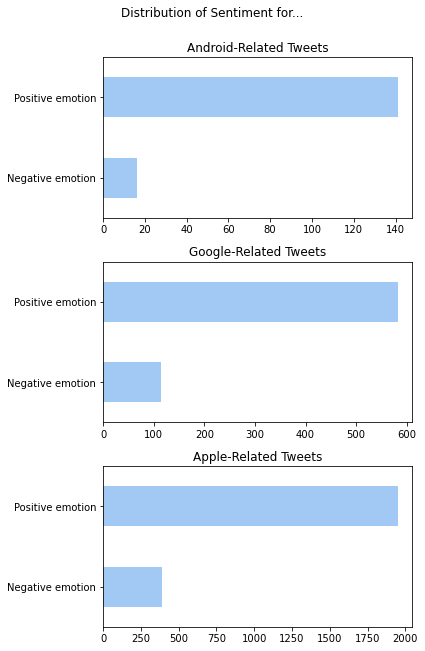

In [20]:
fig, ax = plt.subplots(nrows=3, figsize=(6, 9))

# Android plot
sentiment_counts_by_brand.loc[('Android',)].drop(
    ['No emotion toward brand or product'], axis=0
).plot(kind='barh', ax=ax[0])
ax[0].set_title('Android-Related Tweets')

# Google plot
sentiment_counts_by_brand.loc[('Google',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh', ax=ax[1])
ax[1].set_title('Google-Related Tweets')

# Apple plot
sentiment_counts_by_brand.loc[('Apple',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh', ax=ax[2])
ax[2].set_title('Apple-Related Tweets')

# don't label y-axis
for axis in ax:
    axis.set_ylabel('')
    
# avoid overlap of subplots
fig.suptitle('Distribution of Sentiment for...', y=1)
fig.tight_layout();

In [ ]:
# save Apple plot

sns.set_palette('pastel')

fig, ax = plt.subplots()

# Apple plot
sentiment_counts_by_brand.loc[('Apple',)].drop(
    ['No emotion toward brand or product', "I can't tell"], axis=0
).plot(kind='barh')
ax.set_title('Apple-Related Tweets')
ax.set_ylabel('')

fig.savefig('images/bar1.jpg', bbox_inches='tight');

Generate a pie chart showing the proportion of mentions which went to each brand.

In [21]:
data.groupby(['brand']).count()

tweet_text  object  sentiment
brand                                 
Android         159     159        159
Apple          2409    2409       2409
Google          723     723        723

In [ ]:
keys = ['Android', 'Apple', 'Google']
values = [data.groupby(['brand']).count().loc[key, 'tweet_text'] for key in keys]

explode = [0, 0.05, 0]
palette_color = sns.color_palette('pastel')

fig, ax = plt.subplots()

plt.pie(values, labels=keys, colors=palette_color,
        explode=explode, autopct='%.0f%%')

ax.set(title='Tweets directed at each Brand')

fig.savefig('images/first_pie.jpg', bbox_inches='tight');

## Data Preparation
### Part 1

Clean data by dropping records with ambiguous sentiment or null tweet text.

In [7]:
# replace "I can't tell" in sentiment column with null
data.sentiment = data.sentiment.replace({"I can't tell": None})
# drop records with null value for sentiment
data.dropna(subset='sentiment', inplace=True)

In [8]:
# drop tweet that is missing tweet_text
data.dropna(subset='tweet_text', inplace=True)

In [9]:
data.head()

tweet_text              object   
0  .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone  \
1  @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2  @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3  @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4  @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   

          sentiment   brand  
0  Negative emotion   Apple  
1  Positive emotion   Apple  
2  Positive emotion   Apple  
3  Negative emotion   Apple  
4  Positive emotion  Google

It is not necessary for our use case to train a classifier to recognize neutral tweets; therefore, we will start by building a binary classifier using only the positive and negative tweets.

In [10]:
binary_data = data.loc[data.sentiment.isin(['Positive emotion', 'Negative emotion'])].copy()

Split the data into train, validation and test sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(binary_data['tweet_text'].copy(),
                                                    binary_data['sentiment'].copy(),
                                                    test_size=0.2,
                                                    random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  random_state=seed)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(2128,)
(710,)
(710,)


Label encode the target.

In [15]:
le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

print(y_train_encoded.shape)
print(y_val_encoded.shape)
print(y_test_encoded.shape)
print(pd.Series(y_train_encoded).value_counts(normalize=True))
print(pd.Series(y_val_encoded).value_counts(normalize=True))
print(pd.Series(y_test_encoded).value_counts(normalize=True))

dict(zip(range(len(le.classes_)), le.classes_))

(2128,)
(710,)
(710,)
1    0.839286
0    0.160714
Name: proportion, dtype: float64
1    0.830986
0    0.169014
Name: proportion, dtype: float64
1    0.847887
0    0.152113
Name: proportion, dtype: float64


{0: 'Negative emotion', 1: 'Positive emotion'}

Remove stop words, strip punctuation, and stem or lemmatize tokens.

In [16]:
# clean up (remove punctuation & change to lower case) tweets & remove english stopwords
twitter_stopwords = ['sxsw', 'mention', 'link', 'rt']

stopwords_list = stopwords.words('english') + twitter_stopwords

def clean_up(tweet):
    return ' '.join([word.strip(string.punctuation).lower() for word in tweet.split() if
                     word.strip(string.punctuation).lower() not in stopwords_list])

In [17]:
# stemming
from nltk.stem import PorterStemmer

def get_stems(tweet):
    '''Takes in a string of words and outputs a string of stemmed tokens.'''
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in tweet.split()])

In [18]:
# get stemmed tokens for training data & test data
X_train_stems = X_train.apply(clean_up).apply(get_stems)
X_val_stems = X_val.apply(clean_up).apply(get_stems)
X_test_stems = X_test.apply(clean_up).apply(get_stems)

X_train_stems.head()

2451    i'm head hear talk integr social network dynam...
4980            team android ûò full parti detail reveal
2038    major appl io updat day geniu project manag ca...
4460    town sure check us use googl place foursquar k...
8289                          proof ipad 2 turn douchebag
Name: tweet_text, dtype: object

## Data Understanding
### Part 2

Now that we have tokenized each tweet, we can build a frequency distribution for each sentiment category, for each brand. (It's possible that doing so will reveal additional stop words that ought to be removed, or some other pattern that can be captured in the data.)

To analyze the word distribution for each value of the target, we need a set of all training data with the labels included.

In [36]:
all_train = pd.concat([X_train_stems, y_train], axis=1)
all_train.head()

tweet_text         sentiment
769   googl launch major new social network call cir...  Positive emotion
5757  funni moment panel denni crowley get ipad 2 ow...  Positive emotion
3040  daili ipad go evolve...they'r still imposs dow...  Negative emotion
7052  leav google' marissa mayer keynot interest det...  Positive emotion
4279  google' marissa mayer quot;th mobil phone curs...  Positive emotion

Write a function to build a frequency distribution of the most common *n* words and display the results as a bar graph.

In [37]:
def display_fdist(data, n, normalize=False):
    '''Displays a bar graph representing the top n words in the data.'''
    fdist = FreqDist(' '.join(data.tolist()).split())
    top_n = {x[0]: x[1] for x in fdist.most_common(n)}
    raw = pd.Series(top_n)
    normalized = pd.Series(dict(zip(top_n.keys(), [x/fdist.N() for x in top_n.values()])))
    
    if normalize:
        graph_data = normalized
    else:
        graph_data = raw
    
    fig, ax = plt.subplots(figsize=(4, 4))
    
    sns.barplot(x=graph_data.values, y=graph_data.index, palette='pastel');

Examine the most frequently occurring stems across the entire training data.

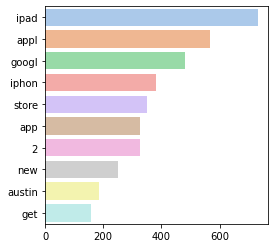

In [38]:
display_fdist(all_train.tweet_text, 10)

Normalizing the frequency distribution above suggests that, for modeling purposes, excluding words which occur more than 1% of the time would eliminate the top 10 words, and excluding words which occur more than 5% of the time would not eliminate any of the vocabulary.

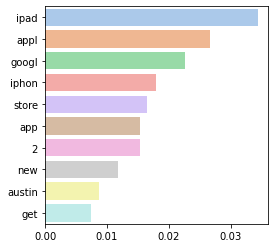

In [39]:
display_fdist(all_train.tweet_text, 10, normalize=True)

Examine the top 20 words in the frequency distribution for negative tweets.

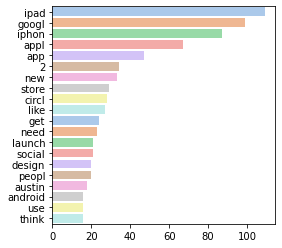

In [40]:
display_fdist(all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'], 20)

Examine the top 20 words in the frequency distribution for positive tweets.

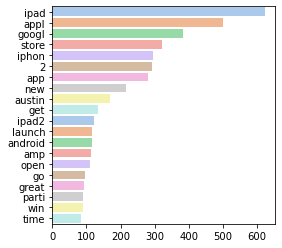

In [41]:
display_fdist(all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'], 20)

Build a frequency distribution that includes bigrams (and possible trigrams.)

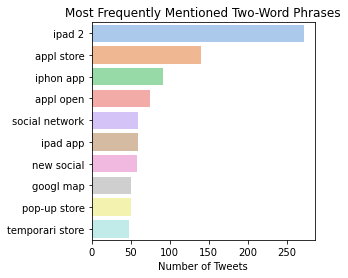

In [42]:
# build a frequency distribution that includes bigrams and possibly trigrams
top10 = FreqDist(nltk.bigrams(' '.join(all_train.tweet_text.tolist()).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index, palette='pastel')

ax.set(title='Most Frequently Mentioned Two-Word Phrases', xlabel='Number of Tweets')

fig.savefig('images/bar2.jpg', bbox_inches='tight');

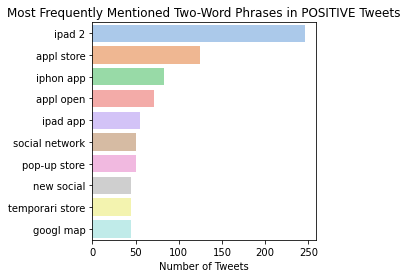

In [43]:
# build a frequency distribution for bigrams in POSITIVE tweets
top10 = FreqDist(nltk.bigrams(' '.join(
    all_train.loc[all_train.sentiment=='Positive emotion', 'tweet_text'].tolist()
).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index, palette='pastel')

ax.set(title='Most Frequently Mentioned Two-Word Phrases in POSITIVE Tweets', xlabel='Number of Tweets')

fig.savefig('images/bar3.jpg', bbox_inches='tight');

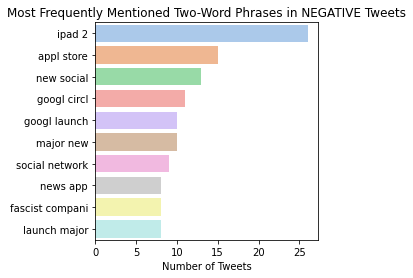

In [44]:
# build a frequency distribution for bigrams in NEGATIVE tweets
top10 = FreqDist(nltk.bigrams(' '.join(
    all_train.loc[all_train.sentiment=='Negative emotion', 'tweet_text'].tolist()
).split())).most_common(10)
bigram_fdist = pd.Series({x[0][0] + ' ' + x[0][1]:x[1] for x in top10})

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(x=bigram_fdist.values, y=bigram_fdist.index, palette='pastel')

ax.set(title='Most Frequently Mentioned Two-Word Phrases in NEGATIVE Tweets', xlabel='Number of Tweets')

fig.savefig('images/bar4.jpg', bbox_inches='tight');

## Data Understanding
### Part 3

Earlier in this project, I built an LDA topic model to try to determine the most prevalent topics discussed in positive, negative and all tweets. The results were not particularly enlightening, and, so, are not included here, but you can see [my first notebook](Archives/nb1_multiclass_classifier.ipynb) in the Archives directory of this project and scroll down to "Data Understanding: Topic Modeling" to see my work.

## Modeling

Models to try:

- Naive Bayes
- Logistic Regression
- Random Forest --> XG Boost
- Support Vector Classifier --> SVC with linear, polynomial kernels

In [69]:
nb = MultinomialNB()
lr = LogisticRegression(random_state=seed)
rf = RandomForestClassifier(random_state=seed)
svc = SVC(random_state=seed)

Table of Contents (Modeling Section)

- [Select a vectorization technique (for each classifier)](#part1)
    - [Tune count vectorization](#part1a)
    - [Test tfidf vectorization](#part1b)
- [Test the effect of scaling after vectorization](#part2)
- [Tune classifier hyperparameters](#part3)
- [Test best model on validation set](#part4)
    - view confusion matrix, feature importance and explanations of most positive and most negative tweets
- [Do further preprocessing and hyperparameter tuning](#part5) if suggested by model's performance on validation set
- [Test best model on hold out test set](#part6)

<a id="part1"></a>

### Select a Vectorization Technique

<a id="part1a"></a>

Try count vectorization with different settings.

NAIVE BAYES / Tuning Count Vectorization

[go to next](#next1)

In [70]:
# naive bayes; tuning count vectorization
# BASELINE
nb_scores = []
nb_vectorizers = []

count = CountVectorizer()
nb_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', nb)
])

nb_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Baseline score: {nb_scores[-1]}')

Baseline score: 0.8604335935689359


In [71]:
# naive bayes; tuning count vectorization
# + BIGRAMS

count = CountVectorizer(ngram_range=(1, 2))
nb_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', nb)
])

nb_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with bigrams: {nb_scores[-1]}')

Score with bigrams: 0.8712409861141461


In [72]:
# naive bayes; tuning count vectorization
# apply min_df and max_df limits

count = CountVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.95)
nb_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', nb)
])

nb_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with min_df and max_df 5% cutoffs: {nb_scores[-1]}')

Score with min_df and max_df 5% cutoffs: 0.8223736400537689


In [73]:
# naive bayes; tuning count vectorization
# tune min_df and max_df limits

count = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.99)
nb_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', nb)
])

nb_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with min_df and max_df 1% cutoffs: {nb_scores[-1]}')

Score with min_df and max_df 1% cutoffs: 0.7833555162663807


In [76]:
# naive bayes; tuning count vectorization
# apply max_features limit

count = CountVectorizer(ngram_range=(1, 2), max_features=12000)
nb_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', nb)
])

nb_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with 12,000 features: {nb_scores[-1]}')

Score with 12,000 features: 0.8712409861141461


In [79]:
# naive bayes; tuning count vectorization
# tune max_features limit

max_features_possibilities = [200, 500, 1000, 5000, 9000, 12000, 16000]

for max_features in max_features_possibilities:

    count = CountVectorizer(ngram_range=(1, 2), max_features=max_features)
    nb_vectorizers.append(count)

    pipe = Pipeline(steps=[
        ('vectorizer', count),
        ('classifier', nb)
    ])

    nb_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
    print(f'Score with {max_features} features: {nb_scores[-1]}')

Score with 200 features: 0.7833561784434865
Score with 500 features: 0.8068608169941132
Score with 1000 features: 0.8172033612109896
Score with 5000 features: 0.8627829979406293
Score with 9000 features: 0.8717124562135389
Score with 12000 features: 0.8712409861141461
Score with 16000 features: 0.8712409861141461


<u>Conclusion</u>

Including bigrams and imposing a limit of 9,000 on the maximum number of features results in an improvement of 0.011 (or 1.1%) on the validation accuracy of the baseline naive bayes model. (9,000 features is a little more than half of the features included without any limit when the vectorizer is fit to the entire training data, with bigrams.)

<a id='next1'></a>

LOGISTIC REGRESSION / Tuning Count Vectorization

[go to next](next2)

In [82]:
# logistic regression; tuning count vectorization
# BASELINE
lr_scores = []
lr_vectorizers = []

count = CountVectorizer()
lr_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', lr)
])

lr_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Baseline score: {lr_scores[-1]}')

Baseline score: 0.8670116609388346


In [83]:
# logistic regression; tuning count vectorization
# + BIGRAMS

count = CountVectorizer(ngram_range=(1, 2))
lr_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', lr)
])

lr_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with bigrams: {lr_scores[-1]}')

Score with bigrams: 0.8735910526629452


In [84]:
# logistic regression; tuning count vectorization
# apply min_df and max_df limits

count = CountVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.95)
lr_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', lr)
])

lr_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with min_df and max_df 5% cutoffs: {lr_scores[-1]}')

Score with min_df and max_df 5% cutoffs: 0.8392863055152731


In [85]:
# logistic regression; tuning count vectorization
# tuning min_df and max_df limits

count = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.99)
lr_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', lr)
])

lr_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with min_df and max_df 1% cutoffs: {lr_scores[-1]}')

Score with min_df and max_df 1% cutoffs: 0.83129316567009


In [86]:
# logistic regression; tuning count vectorization
# apply and tune max_features limit

max_features_possibilities = [200, 500, 1000, 5000, 9000, 12000, 16000]

for max_features in max_features_possibilities:

    count = CountVectorizer(ngram_range=(1, 2), max_features=max_features)
    lr_vectorizers.append(count)

    pipe = Pipeline(steps=[
        ('vectorizer', count),
        ('classifier', lr)
    ])

    lr_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
    print(f'Score with {max_features} features: {lr_scores[-1]}')

Score with 200 features: 0.8298853771429707
Score with 500 features: 0.8477409828032606
Score with 1000 features: 0.8594906533701504
Score with 5000 features: 0.8674824688611217
Score with 9000 features: 0.8698298867014972
Score with 12000 features: 0.8731209069177641
Score with 16000 features: 0.8735910526629452


<u>Conclusion</u>

Adding bigrams resulted in a 0.007 (or 0.7%) improvement in the validation accuracy of a baseline logistic regression model.

<a id='next2'></a>

RANDOM FOREST / Tuning Count Vectorization

[go to next](#next3)

In [88]:
# random forest; tuning count vectorization
# BASELINE
rf_scores = []
rf_vectorizers = []

count = CountVectorizer()
rf_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', rf)
])

rf_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Baseline score: {rf_scores[-1]}')

Baseline score: 0.8754709734665633


In [89]:
# random forest; tuning count vectorization
# + BIGRAMS

count = CountVectorizer(ngram_range=(1, 2))
rf_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', rf)
])

rf_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with bigrams: {rf_scores[-1]}')

Score with bigrams: 0.8684220981743778


In [90]:
# random forest; tuning count vectorization
# apply min_df and max_df limits

count = CountVectorizer(min_df=0.05, max_df=0.95)
rf_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', rf)
])

rf_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with min_df and max_df 5% cutoffs: {rf_scores[-1]}')

Score with min_df and max_df 5% cutoffs: 0.8265996543435508


In [91]:
# random forest; tuning count vectorization
# tuning min_df and max_df limits

count = CountVectorizer(min_df=0.01, max_df=0.99)
rf_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', rf)
])

rf_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with min_df and max_df 1% cutoffs: {rf_scores[-1]}')

Score with min_df and max_df 1% cutoffs: 0.8298774310177


In [93]:
# random forest; tuning count vectorization
# apply and tune max_features limit

max_features_possibilities = [200, 500, 1000, 2000, 3000]

for max_features in max_features_possibilities:

    count = CountVectorizer(max_features=max_features)
    rf_vectorizers.append(count)

    pipe = Pipeline(steps=[
        ('vectorizer', count),
        ('classifier', rf)
    ])

    rf_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
    print(f'Score with {max_features} features: {rf_scores[-1]}')

Score with 200 features: 0.8364641066899754
Score with 500 features: 0.8632498328002808
Score with 1000 features: 0.8632511571544925
Score with 2000 features: 0.8684220981743778
Score with 3000 features: 0.8750014898984881


<u>Conclusion</u>

The baseline random forest model had the best validation accuracy when a count vectorizer without any special settings is applied.

<a id='next3'></a>

SUPPORT VECTOR CLASSIFIER / Tuning Count Vectorization

[go to next](#next4)

In [94]:
# support vector classifier; tuning count vectorization
# BASELINE
svc_scores = []
svc_vectorizers = []

count = CountVectorizer()
svc_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', svc)
])

svc_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Baseline score: {svc_scores[-1]}')

Baseline score: 0.856671765430382


In [95]:
# support vector classifier; tuning count vectorization
# + BIGRAMS

count = CountVectorizer(ngram_range=(1, 2))
svc_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', svc)
])

svc_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with bigrams: {svc_scores[-1]}')

Score with bigrams: 0.8594926399014681


In [96]:
# support vector classifier; tuning count vectorization
# apply min_df and max_df limits

count = CountVectorizer(ngram_range=(1, 2), min_df=0.05, max_df=0.95)
svc_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', svc)
])

svc_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with min_df and max_df 5% cutoffs: {svc_scores[-1]}')

Score with min_df and max_df 5% cutoffs: 0.8383453518478051


In [97]:
# support vector classifier; tuning count vectorization
# tuning min_df and max_df limits

count = CountVectorizer(ngram_range=(1, 2), min_df=0.01, max_df=0.99)
svc_vectorizers.append(count)

pipe = Pipeline(steps=[
    ('vectorizer', count),
    ('classifier', svc)
])

svc_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
print(f'Score with min_df and max_df 1% cutoffs: {svc_scores[-1]}')

Score with min_df and max_df 1% cutoffs: 0.8444572465351583


In [99]:
# support vector classifier; tuning count vectorization
# apply and tune max_features limit

max_features_possibilities = [200, 500, 1000, 5000, 8000, 12000, 16000]

for max_features in max_features_possibilities:

    count = CountVectorizer(ngram_range=(1, 2), max_features=max_features)
    svc_vectorizers.append(count)

    pipe = Pipeline(steps=[
        ('vectorizer', count),
        ('classifier', svc)
    ])

    svc_scores.append(np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3)))
    print(f'Score with {max_features} features: {svc_scores[-1]}')

Score with 200 features: 0.8449267301032334
Score with 500 features: 0.8500930358833774
Score with 1000 features: 0.8557327982942318
Score with 5000 features: 0.856201619685201
Score with 8000 features: 0.857612056920744
Score with 12000 features: 0.859022494156287
Score with 16000 features: 0.8594926399014681


<u>Conclusion</u>

Including bigrams results in an improvement of 0.003 (about 0.3%) on the validation accuracy of the baseline support vector classifier model.

<a id='next4'></a>
<a id='part1b'></a>

Test the effect of using tfidf vectorization in place of count vectorization.

[go to conclusion](#next5)

In [102]:
# naive bayes; test tfidf vectorization

tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=9000)

pipe = Pipeline(steps=[
    ('vectorizer', tfidf),
    ('classifier', nb)
])

np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.8472748101207149

In [104]:
# logistic regression; test tfidf vectorization

tfidf = TfidfVectorizer(ngram_range=(1, 2))

pipe = Pipeline(steps=[
    ('vectorizer', tfidf),
    ('classifier', lr)
])

np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.8406960805737103

In [106]:
# random forest; test tfidf vectorization

tfidf = TfidfVectorizer()

pipe = Pipeline(steps=[
    ('vectorizer', tfidf),
    ('classifier', rf)
])

np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.8670116609388346

In [108]:
# support vector classifier; test tfidf vectorization

tfidf = TfidfVectorizer(ngram_range=(1, 2))

pipe = Pipeline(steps=[
    ('vectorizer', tfidf),
    ('classifier', svc)
])

np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.8609017527827992

<a id='next5'></a>

<u>Conclusion</u>

When using tfidf vectorization, the baseline models perform just slightly worse, but almost the same, as when count vectorization is used, except in the case of the support vector classifier. The baseline SVC model performs slightly better with tfidf vectorization; the baseline naive bayes, random forest and logistic regression models perform slightly better with count vectorization.

**Final vectorizers**

In [110]:
nb_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=9000)
lr_vectorizer = CountVectorizer(ngram_range=(1, 2))
rf_vectorizer = CountVectorizer()
svc_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

<a id='part2'></a>

### Test Effect of Scaling After Vectorization

Does scaling the data after vectorization make any difference in the performance of the baseline model?

[go to conclusion](#next6)

*Scalers do not accept sparse input, so create a wrapper for vectorizers to return a dense matrix instead.*

In [20]:
class WrappedCountVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, ngram_range=(1,1), max_features=None):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.vectorizer = CountVectorizer(ngram_range=self.ngram_range,
                                          max_features=self.max_features)
        
    def fit(self, documents, labels=None):
        # fit scikit learn vectorizer
        self.vectorizer.fit(documents)
        # store vocabulary to be accessed later
        self.vocabulary_ = self.vectorizer.vocabulary_
        
        return self
    
    def transform(self, documents):
        # transform documents using scikit learn vectorizer
        return pd.DataFrame(self.vectorizer.transform(documents).todense())

In [123]:
nb_vectorizer = WrappedCountVectorizer(ngram_range=(1, 2), max_features=9000)
lr_vectorizer = WrappedCountVectorizer(ngram_range=(1, 2))
rf_vectorizer = WrappedCountVectorizer()

NAIVE BAYES / Scaling After Vectorization

In [120]:
# naive bayes; test scaling after vectorization

mms = MinMaxScaler() # naive bayes requires 0 to 1 scaling

pipe = Pipeline(steps=[
    ('vectorizer', nb_vectorizer),
    ('scaler', mms),
    ('classifier', nb)
])

np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3, error_score='raise'))

0.8712423104683579

Scaling after vectorization results in a decrease of 0.05% in the validation accuracy of the baseline naive bayes model.

RANDOM FOREST / Scaling After Vectorization

In [124]:
# random forest; test scaling after vectorization

ss = StandardScaler()

pipe = Pipeline(steps=[
    ('vectorizer', rf_vectorizer),
    ('scaler', ss),
    ('classifier', rf)
])

np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3, error_score='raise'))

0.8754709734665633

Scaling after vectorization makes no difference to the validation accuracy of the baseline random forest model.

LOGISTIC REGRESSION / Scaling After Vectorization

In [135]:
# logistic regression; test scaling after vectorization

ss = StandardScaler()

lr = LogisticRegression(random_state=seed, max_iter=10000) # need more iterations to converge

pipe = Pipeline(steps=[
    ('vectorizer', lr_vectorizer),
    ('scaler', ss),
    ('classifier', lr)
])

np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3, error_score='raise'))

0.8660720316255786

Scaling after vectorization results in a decrease of 0.008 in the validation accuracy of the baseline logistic regression model.

*Create wrapped for tfidf vectorizer, for support vector classifier.*

In [136]:
class WrappedTfidfVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, ngram_range=(1,1), max_features=None):
        self.ngram_range = ngram_range
        self.max_features = max_features
        self.vectorizer = TfidfVectorizer(ngram_range=self.ngram_range,
                                          max_features=self.max_features)
        
    def fit(self, documents, labels=None):
        # fit scikit learn vectorizer
        self.vectorizer.fit(documents)
        
        return self
    
    def transform(self, documents):
        # transform documents using scikit learn vectorizer
        return pd.DataFrame(self.vectorizer.transform(documents).todense())

In [138]:
svc_vectorizer = WrappedTfidfVectorizer(ngram_range=(1, 2))

SUPPORT VECTOR CLASSIFIER / Scaling After Vectorization

In [145]:
# support vector classifier; test scaling after vectorization
# TIME TO RUN: 2 min 6 s

ss = StandardScaler()

pipe = Pipeline(steps=[
    ('vectorizer', svc_vectorizer),
    ('scaler', ss),
    ('classifier', svc)
])

np.mean(cross_val_score(pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3, error_score='raise'))

CPU times: user 3min 5s, sys: 48.5 s, total: 3min 53s
Wall time: 2min 6s


0.857612056920744

Scaling after vectorization results in a decrease of 0.003 in the validation accuracy of the baseline support vector machine model.

<a id='next6'></a>

<u>Conclusion</u>

Scaling after vectorization does not improve the performance of any of the baseline models.

<a id="part3"></a>

### Tuning Classifier Hyperparameters

[Logistic Regression](#next7)

[Random Forest](#next8)

[XG Boost](#next9)

[Support Vector Classifier](#next10)

<a id='next7'></a>

#### Logistic Regression

In [171]:
data.loc[data.sentiment.isin(['Positive emotion', 'Negative emotion']), 'sentiment'].value_counts(normalize=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


sentiment
Positive emotion    0.839346
Negative emotion    0.160654
Name: proportion, dtype: float64

Vectorizer Settings

In [148]:
lr = LogisticRegression(random_state=seed)
lr_vectorizer = WrappedCountVectorizer(ngram_range=(1, 2))

lr_pipe = Pipeline(steps=[
    ('vec', lr_vectorizer),
    ('clf', lr)
])

Baseline Accuracy Score

In [149]:
# baseline

np.mean(cross_val_score(lr_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.8735910526629452

*Keep in mind that the dataset is imbalanced; a classifier which always choose positive would have an overall accuracy of ~84%.*

Check for Overfitting

In [154]:
results = cross_validate(lr_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3, return_train_score=True)

print(f"Mean Training Accuracy: {np.mean(results['train_score'])}")

Mean Training Accuracy: 0.996710802054063


Increase Strength of (L2) Regularization

In [160]:
param_grid = [
    {'clf__C': [0.001, 0.01, 0.1],
     'clf__random_state': [seed]}
]

grid_search = GridSearchCV(lr_pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True)

grid_search.fit(X_train_stems, y_train_encoded)

pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_clf__C   
0       0.919512      0.172670         0.208835        0.027141        0.001  \
1       0.769537      0.030348         0.183184        0.007147         0.01   
2       1.273730      0.022152         0.179204        0.001738          0.1   

              params  split0_test_score  split1_test_score  split2_test_score   
0  {'clf__C': 0.001}           0.839437           0.839210           0.839210  \
1   {'clf__C': 0.01}           0.839437           0.839210           0.839210   
2    {'clf__C': 0.1}           0.853521           0.847673           0.850494   

   mean_test_score  std_test_score  rank_test_score  split0_train_score   
0         0.839286        0.000107                2             0.83921  \
1         0.839286        0.000107                2             0.83921   
2         0.850563        0.002388                1             0.88646   

   split1_train_score  split2_train_score  mean_train_score  std_train_score  
0            0.839323            0.839323          0.839286         0.000053  
1            0.839323            0.839323          0.839286         0.000053  
2            0.881607            0.880197          0.882755         0.002682

A regularization strength of 1 / 0.01 (so 100) results in a model which is neither under nor overfit. However, the validation accuracy is lower than that of the original overfit baseline model.

Change the Type of Regularization

In [163]:
param_grid = [
    {'clf__C': [0.001, 0.01, 0.1],
     'clf__penalty': ['l1'],
     'clf__solver': ['saga'],
     'clf__random_state': [seed]}
]

grid_search = GridSearchCV(lr_pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True,
                           error_score='raise')

grid_search.fit(X_train_stems, y_train_encoded)

pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_clf__C   
0       0.577137      0.022957         0.135134        0.007445        0.001  \
1       1.165228      0.436598         0.130015        0.000559         0.01   
2       6.191306      0.824746         0.131977        0.002501          0.1   

  param_clf__penalty param_clf__solver   
0                 l1              saga  \
1                 l1              saga   
2                 l1              saga   

                                              params  split0_test_score   
0  {'clf__C': 0.001, 'clf__penalty': 'l1', 'clf__...           0.839437  \
1  {'clf__C': 0.01, 'clf__penalty': 'l1', 'clf__s...           0.839437   
2  {'clf__C': 0.1, 'clf__penalty': 'l1', 'clf__so...           0.839437   

   split1_test_score  split2_test_score  mean_test_score  std_test_score   
0            0.83921            0.83921         0.839286        0.000107  \
1            0.83921            0.83921         0.839286        0.000107   
2            0.83921            0.83921         0.839286        0.000107   

   rank_test_score  split0_train_score  split1_train_score   
0                1             0.83921            0.839323  \
1                1             0.83921            0.839323   
2                1             0.83921            0.839323   

   split2_train_score  mean_train_score  std_train_score  
0            0.839323          0.839286         0.000053  
1            0.839323          0.839286         0.000053  
2            0.839323          0.839286         0.000053

Using the l1 penalty decreased performance, perhaps because it acts similarly (in some ways) to specifying a maximum number of features allowed by the vectorizer.

Implement Class Weights

In [167]:
param_grid = [
    {'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
     'clf__class_weight': ['balanced'],
     'clf__max_iter': [10000],
     'clf__random_state': [seed]}
]

grid_search = GridSearchCV(lr_pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True,
                           error_score='raise')

grid_search.fit(X_train_stems, y_train_encoded)

pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_clf__C   
0       0.727892      0.094876         0.194915        0.006704        0.001  \
1       0.765387      0.025808         0.192513        0.005418         0.01   
2       1.385873      0.041754         0.194115        0.008211          0.1   
3       2.427039      0.174984         0.195752        0.006536            1   
4       3.806184      0.057103         0.182474        0.007505           10   
5       6.059097      0.519627         0.188612        0.009722          100   

  param_clf__class_weight param_clf__max_iter   
0                balanced               10000  \
1                balanced               10000   
2                balanced               10000   
3                balanced               10000   
4                balanced               10000   
5                balanced               10000   

                                              params  split0_test_score   
0  {'clf__C': 0.001, 'clf__class_weight': 'balanc...           0.767606  \
1  {'clf__C': 0.01, 'clf__class_weight': 'balance...           0.790141   
2  {'clf__C': 0.1, 'clf__class_weight': 'balanced...           0.833803   
3  {'clf__C': 1, 'clf__class_weight': 'balanced',...           0.860563   
4  {'clf__C': 10, 'clf__class_weight': 'balanced'...           0.859155   
5  {'clf__C': 100, 'clf__class_weight': 'balanced...           0.861972   

   split1_test_score  split2_test_score  mean_test_score  std_test_score   
0           0.700987           0.705219         0.724604        0.030456  \
1           0.775740           0.755994         0.773959        0.013997   
2           0.847673           0.854725         0.845400        0.008691   
3           0.871650           0.873061         0.868425        0.005589   
4           0.870240           0.873061         0.867485        0.006002   
5           0.868829           0.873061         0.867954        0.004569   

   rank_test_score  split0_train_score  split1_train_score   
0                6            0.838505            0.818887  \
1                5            0.887165            0.886540   
2                4            0.985896            0.985201   
3                1            0.997884            0.997886   
4                3            0.997884            0.999295   
5                2            0.998590            0.999295   

   split2_train_score  mean_train_score  std_train_score  
0            0.804087          0.820493         0.014097  
1            0.862579          0.878761         0.011445  
2            0.988020          0.986372         0.001199  
3            0.997181          0.997650         0.000332  
4            0.997886          0.998355         0.000665  
5            0.998591          0.998825         0.000332

Adjusting the class weight to "balanced" did not improve validation accuracy over the baseline.

<a id='next8'></a>

#### Random Forest

Vectorizer Settings

In [208]:
rf = RandomForestClassifier(random_state=seed)
rf_vectorizer = WrappedCountVectorizer()

rf_pipe = Pipeline(steps=[
    ('vec', rf_vectorizer),
    ('clf', rf)
])

Baseline Accuracy Score

In [209]:
# baseline

np.mean(cross_val_score(rf_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.8754709734665633

Check for Overfitting

In [210]:
results = cross_validate(rf_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3, return_train_score=True)

print(f"Mean Training Accuracy: {np.mean(results['train_score'])}")

Mean Training Accuracy: 0.9988252982808038


Grid Search for Better Hyperparameters

In [ ]:
# TIME TO RUN: 1 hr 2 min (and 3 seconds)

param_grid = [
    {'clf__n_estimators': [50, 100],
     'clf__max_depth': [2, 10],
     'clf__random_state': [seed]},
    {'clf__max_depth': [10, 20, 50, None],
     'clf__max_features': [0.1, 0.3, 0.5, 0.7, 0.9],
     'clf__max_samples': [0.1, 0.3, 0.5, 0.7, 0.9],
     'clf__class_weight': ['balanced_subsample', None],
     'clf__random_state': [seed]}
]

grid_search = GridSearchCV(rf_pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True)

grid_search.fit(X_train_stems, y_train_encoded)

print(f'Best Estimator: {grid_search.best_estimator_}')
print(f'Best Score: {grid_search.best_score_}')

Best Estimator: Pipeline(steps=[('vec', WrappedCountVectorizer()),
                ('clf',
                 RandomForestClassifier(max_features=0.1, max_samples=0.9,
                                        random_state=23984))])
Best Score: 0.8768807485250004
CPU times: user 1h 49s, sys: 764 ms, total: 1h 49s
Wall time: 1h 2min 3s


The best random forest classifier so far considers 10% of all features when making a split, and draws a sample (with replacement) equal in size to 90% of the training data to build each tree. This improves validation performance by 0.001 (about 0.1%) over the baseline.

<a id='next9'></a>

#### XG Boost

In [214]:
xgb = XGBClassifier()

xgb_pipe = Pipeline(steps=[
    ('vec', rf_vectorizer), # use best vectorizer settings for random forest
    ('clf', xgb)
])

Baseline Accuracy Score

In [215]:
# baseline

np.mean(cross_val_score(xgb_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.8505605329201348

The baseline score for XG Boost is, surprisingly, lower than that of a non-boosted random forest.

<a id='next10'></a>

#### Support Vector Classifier

Vectorizer Settings

In [224]:
svc = SVC(random_state=seed)
svc_vectorizer = WrappedTfidfVectorizer(ngram_range=(1, 2))
ss = StandardScaler()

svc_pipe = Pipeline(steps=[
    ('vec', svc_vectorizer),
    ('scale', ss),
    ('clf', svc)
])

Baseline Accuracy Score

In [225]:
# baseline

np.mean(cross_val_score(svc_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3))

0.857612056920744

^^ compare to 0.8609 ...

Check for Overfitting

In [226]:
results = cross_validate(svc_pipe, X_train_stems, y_train_encoded, scoring='accuracy', cv=3, return_train_score=True)

print(f"Mean Training Accuracy: {np.mean(results['train_score'])}")

Mean Training Accuracy: 0.9687502174299826


Grid Search for Better Hyperparameters

- Pick a kernel

In [227]:
# TIME TO RUN: 17 min (and 17 seconds)

param_grid = [
    {'clf__kernel': ['rbf', 'sigmoid'],
     'clf__random_state': [seed]},
    {'clf__kernel': ['poly'],
     'clf__degree': [1, 2, 3, 4],
     'clf__random_state': [seed]}
]

grid_search = GridSearchCV(svc_pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True)

grid_search.fit(X_train_stems, y_train_encoded)

print(f'Best Estimator: {grid_search.best_estimator_}')
print(f'Best Score: {grid_search.best_score_}')

Best Estimator: Pipeline(steps=[('vec', WrappedTfidfVectorizer(ngram_range=(1, 2))),
                ('scale', StandardScaler()),
                ('clf', SVC(degree=1, kernel='poly', random_state=23984))])
Best Score: 0.8660740181568962
CPU times: user 27min 31s, sys: 5min 4s, total: 32min 36s
Wall time: 17min 17s


A degree 1 polynomial, a.k.a. linear, kernel performs the best.

- Determine values of gamma and C

In [228]:
# TIME TO RUN: 48 min (and 38 seconds)

param_grid = [
    {'clf__kernel': ['linear'],
     'clf__gamma': [0.0001, 0.001, 0.01, 0.1],
     'clf__C': [0.001, 0.01, 0.1, 1, 1000],
     'clf__random_state': [seed]}
]

grid_search = GridSearchCV(svc_pipe, param_grid, scoring='accuracy', cv=3, return_train_score=True)

grid_search.fit(X_train_stems, y_train_encoded)

print(f'Best Estimator: {grid_search.best_estimator_}')
print(f'Best Score: {grid_search.best_score_}')

Best Estimator: Pipeline(steps=[('vec', WrappedTfidfVectorizer(ngram_range=(1, 2))),
                ('scale', StandardScaler()),
                ('clf',
                 SVC(C=0.001, gamma=0.0001, kernel='linear',
                     random_state=23984))])
Best Score: 0.873592377017157
CPU times: user 1h 18min 48s, sys: 12min 27s, total: 1h 31min 15s
Wall time: 48min 38s


The best support vector classifier so far has a linear kernel, a C value of 0.001 (so a regularization strength of 1000) and a gamma value of 0.001.

#### Summary of Hyperparameter Tuning (for all Classifiers)

| Algorithm | Best Mean Validation Accuracy | Hyperparameters |
| --- | --- | --- |
| Logistic Regression | 87.359% | Baseline |
| Random Forest | 87.688% | max_features=0.1, max_samples=0.9 |
| XG Boost | 85.056% | Baseline (not tuned) |
| Support Vector Classifier | 87.359% | linear kernel, C=0.001, gamma=0.001 |

XG Boost was not tuned because baseline score was lower than baseline score of random forest.

<a id="part4"></a>

### Test Best Model so Far on Validation Set

Confirm best model (so far) hyperparameters and vectorizer settings:

In [248]:
rf = RandomForestClassifier(max_features=0.1, max_samples=0.9, random_state=seed)
rf_vectorizer = WrappedCountVectorizer()

rf_pipe = Pipeline(steps=[
    ('vec', rf_vectorizer),
    ('clf', rf)
])

Fit to training data and score on validation data:

In [249]:
rf_pipe.fit(X_train_stems, y_train_encoded)

rf_pipe.score(X_val_stems, y_val_encoded)

0.8492957746478873

This classifier performs only slightly better than a majority class selector.

Examine model performance more closely.

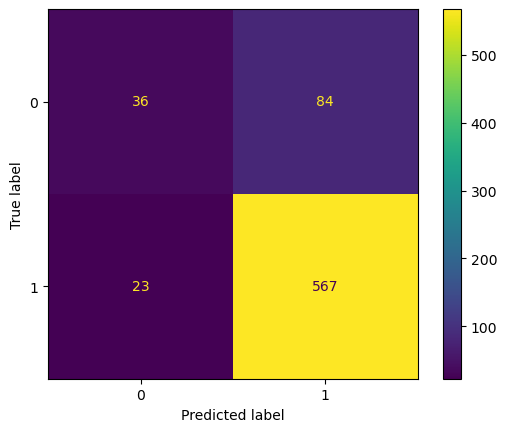

In [242]:
ConfusionMatrixDisplay(confusion_matrix(y_val_encoded, rf_pipe.predict(X_val_stems))).plot();

Which features are the most important to the model?

In [281]:
feats = [x[0] for x in sorted(rf_pipe['vec'].vocabulary_.items(), key = lambda x: x[1])]

feat_importances = rf_pipe['clf'].feature_importances_

feature_importances = dict(zip(feats, feat_importances))

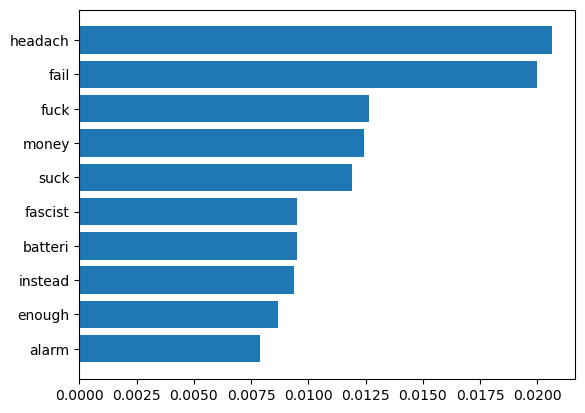

In [283]:
top_10_feats = [x[0] for x in sorted(feature_importances.items(), key = lambda x: x[1], reverse=True)][:10]
top_10_importances = [feature_importances[feat] for feat in top_10_feats]

top_10_feats.reverse()
top_10_importances.reverse()

fig, ax = plt.subplots()

plt.barh(top_10_feats, top_10_importances);

Most Negative Tweets:

In [284]:
probability_negative = list(rf_pipe.predict_proba(pd.concat([X_train_stems, X_val_stems], axis=0))[:, 0])

top_5_most_negative_tweets = []

for i in range(5):
    most_negative_iloc = np.argmax(probability_negative)
    true_index = pd.concat([X_train_stems, X_val_stems], axis=0).index[most_negative_iloc]
    
    top_5_most_negative_tweets.append(data.loc[true_index, 'tweet_text'])
    
    probability_negative.pop(most_negative_iloc)

In [285]:
for tweet in top_5_most_negative_tweets:
    print(tweet)

IPad Design Headaches. interface metaphor. Looks like a book, make it behave like a book. Simple stuff, but often forgotten. #SXSW
It is never more apparent than at #sxsw how nice it would be if apple made stuff w/ removable batteries. #alwayshavingtoplugin #gsdm
I love how #sxsw is an alt universe where everyone uses Apple products and @mention is the fastest way to reach someone
Can't wait anymore!!! :)) &quot;Google to Launch Major New Social Network Called Circles&quot; (via @mention {link} #google #circles #sxsw
RT @mention Good talk from AKQAs @mention on iPad interface w/ callback to design principles. My wish: go beyond media/marketing examples. #fb #SxSW


Most Positive Tweets:

A small problem arose when determining the "most positive tweets" in the dataset; the model is so confident in so many of its positive predictions that there are 1,162 tweets for which the model has 100% confidence that the tweet is positive.

In [306]:
probability_positive = list(rf_pipe.predict_proba(pd.concat([X_train_stems, X_val_stems], axis=0))[:, 1])

# remove ones
flag = 1
while flag == 1:
    try:
        probability_positive.remove(1)
        flag=1
    except:
        flag=0

top_5_most_positive_tweets = []
true_indices = []

for i in range(5):
    most_positive_iloc = np.argmax(probability_positive)
    true_index = pd.concat([X_train_stems, X_val_stems], axis=0).index[most_positive_iloc]
    true_indices.append(true_index)
    
    top_5_most_positive_tweets.append(data.loc[true_index, 'tweet_text'])
    
    probability_positive.pop(most_positive_iloc)

In [307]:
for tweet in top_5_most_positive_tweets:
    print(tweet)

Will the gadget-addicted Apple Fanboy manage to come home from #SXSW without an IPad 2? The suspense is intense! It's intense suspense!
RT @mention Buying iPad2? Turn in ur iPad1, Apple store wipes it clean, donates to schools. Mrs. Jobs idea. #Apple #iPad2 #SXSW
In a really long line to get into the ACLU/Google party. Not sure I can wait this out. #sxsw
Proof that the iPad 2 turns you into a douchebag #SXSW {link}
I got turkey! RT @mention Random Apple Fan just bought lunch for everyone in line at #SXSW Popup Apple Store #ipad2 cc/ @mention


Explain the most positive tweets with Lime.

In [308]:
explainer = LimeTextExplainer(class_names=le.classes_)

^^This didn't really work out because there are so many features, and the "importance" is split between them, resulting in lots of tiny, tiny values that just round down to zero.

In [326]:
# example of the problem; show explanation for the first most positive tweet
for i in [true_indices[0]]:
    explanation = explainer.explain_instance(data.loc[i, 'tweet_text'],
                                             rf_pipe.predict_proba,
                                             num_features=10,
                                             labels=[0, 1])
    
    print(explanation.as_list())

[('the', -0.10897289161995628), ('The', -0.10796181368272799), ('It', 0.0011794559390280765), ('manage', 0.0011088076819222115), ('from', -0.0011055848434728273), ('to', 0.0007450245825008063), ('Will', -0.0006908490002674006), ('gadget', -0.000685225173542874), ('2', 0.0006339981229862803), ('Fanboy', -0.0004955279772188746)]


Showing "explanations" for the top 5 most positive tweets:

In [323]:
for i in true_indices:
    explanation = explainer.explain_instance(data.loc[i, 'tweet_text'],
                                             rf_pipe.predict_proba,
                                             num_features=10,
                                             labels=[0, 1])
    explanation.show_in_notebook()
    
    ready = input('Press enter when ready to proceed.')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Press enter when ready to proceed.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Press enter when ready to proceed.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Press enter when ready to proceed.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Press enter when ready to proceed.


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lime/explanation.py:194: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Press enter when ready to proceed.


The model might need a little more context to make better predictions, considering that "douchebag" is a heavily weighted positive term.

Looking at the confusion matrix summarizing the model's performance on the validation data, the model could also potentially be improved by weighting the positive and negative classes equally.

---

<a id="part5"></a>

#### Improve the Model

Try random undersampling to see if we can improve recall of negative tweets (without letting recall of positive tweets fall to an unacceptable level.) Use balanced accuracy to judge the best model.

Overall accuracy: 0.6563380281690141


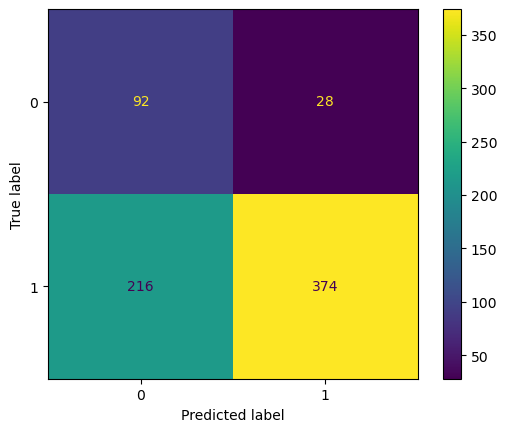

In [25]:
rf_vectorizer = WrappedCountVectorizer()
rus = RandomUnderSampler(random_state=seed)
rf = RandomForestClassifier(max_features=0.1, max_samples=0.9, random_state=seed)

X_train_vectorized = rf_vectorizer.fit_transform(X_train_stems)

X_resampled, y_resampled = rus.fit_resample(X_train_vectorized, y_train_encoded)

rf.fit(X_resampled, y_resampled)

X_val_vectorized = rf_vectorizer.transform(X_val_stems)

print(f'Overall accuracy: {rf.score(X_val_vectorized, y_val_encoded)}')

ConfusionMatrixDisplay(confusion_matrix(y_val_encoded, rf.predict(X_val_vectorized))).plot();

Try different "sampling strategies" for random under sampler; this is the ratio of minority class instances to majority class instances. Naturally, this ratio is a little less than 0.2.

In [33]:
# vectorize
rf_vectorizer = WrappedCountVectorizer()
X_train_vectorized = rf_vectorizer.fit_transform(X_train_stems)
X_val_vectorized = rf_vectorizer.transform(X_val_stems)

# classifier
rf = RandomForestClassifier(max_features=0.1, max_samples=0.9, random_state=seed)

# sampling strategies to try
sampling_strategies = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
scores = []

for sampling_strategy in sampling_strategies:
    
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=seed)
    X_resampled, y_resampled = rus.fit_resample(X_train_vectorized, y_train_encoded)
    rf.fit(X_resampled, y_resampled)
    
    scores.append(balanced_accuracy_score(y_val_encoded, rf.predict(X_val_vectorized)))

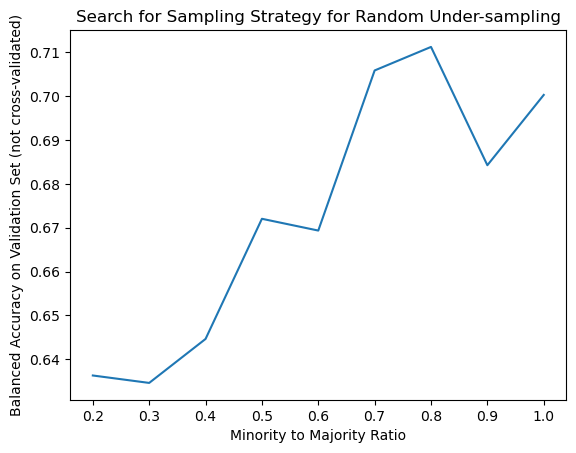

In [34]:
fig, ax = plt.subplots()

plt.plot(sampling_strategies, scores)
ax.set(title='Search for Sampling Strategy for Random Under-sampling',
       xlabel='Minority to Majority Ratio',
       ylabel='Balanced Accuracy on Validation Set (not cross-validated)');

In [36]:
print(f'Best sampling strategy: {sampling_strategies[np.argmax(scores)]}')

Best sampling strategy: 0.8


<a id="part6"></a>

#### Evaluate the Best Model on the Holdout Test Set

Train the best model on the full training data, get the accuracy and balanced accuracy scores on the hold-out test data, and print confusion matrices to visualize the model's performance on each class.

Accuracy on hold out test set: 0.8422535211267606
Balanced accuracy on hold out test set: 0.7436169558262582


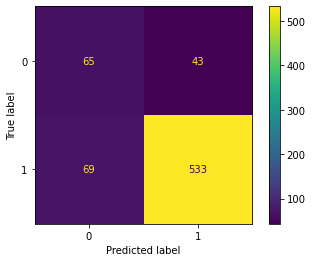

In [21]:
# concatenate training and validation data
full_X_train = pd.concat([X_train_stems, X_val_stems], axis=0)
full_y_train = pd.concat([pd.Series(y_train_encoded, index=X_train_stems.index),
                          pd.Series(y_val_encoded, index=X_val_stems.index)], axis=0)

# vectorize the full training data
rf_vectorizer = WrappedCountVectorizer()
X_train_vectorized = rf_vectorizer.fit_transform(full_X_train)
X_test_vectorized = rf_vectorizer.transform(X_test_stems)

# undersample the vectorized training data
rus = RandomUnderSampler(sampling_strategy=0.8, random_state=seed)
X_resampled, y_resampled = rus.fit_resample(X_train_vectorized, full_y_train)

# fit the best model to the resampled training data
rf = RandomForestClassifier(max_features=0.1, max_samples=0.9, random_state=seed)
rf.fit(X_resampled, y_resampled)

# score on the hold out test set, and view the confusion matrix
y_preds = rf.predict(X_test_vectorized)
print(f'Accuracy on hold out test set: {rf.score(X_test_vectorized, y_test_encoded)}')
print(f'Balanced accuracy on hold out test set: {balanced_accuracy_score(y_test_encoded, y_preds)}')
ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_preds)).plot();

Save the confusion matrix with raw counts to file.

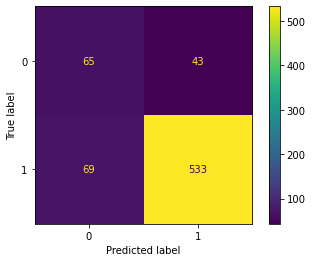

In [23]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_preds)).plot(ax=ax)

fig.savefig('images/confusion_matrix.jpg', bbox_inches='tight');

Create a confusion matrix that shows what percentage of each class is correctly versus incorrectly assigned to a predicted class.

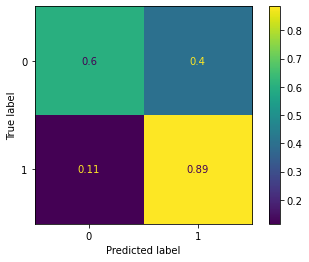

In [22]:
# get recall of each class

ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_preds, normalize='true')).plot();

**Classification Report**

Print a classification report for the best model.

In [50]:
print(classification_report(y_test_encoded, y_preds))

              precision    recall  f1-score   support

           0       0.39      0.58      0.47       107
           1       0.92      0.84      0.88       603

    accuracy                           0.80       710
   macro avg       0.66      0.71      0.67       710
weighted avg       0.84      0.80      0.82       710



The recall for the positive and negative classes are 84% and 58%, respectively.

Precision is at 92% for the positive class and 39% for the negative class.

Unsurprisingly the model generally does a better job predicting the positive (majority) class than the negative class.

**Understanding the Model: Feature Importances**

Since the best model turned out to be a random forest, we can use scikit learn's random forest's built-in "feature importances" attribute to understand a little bit more about how the model is making its decisions, and which features (in this case, words) are most influential on classification.

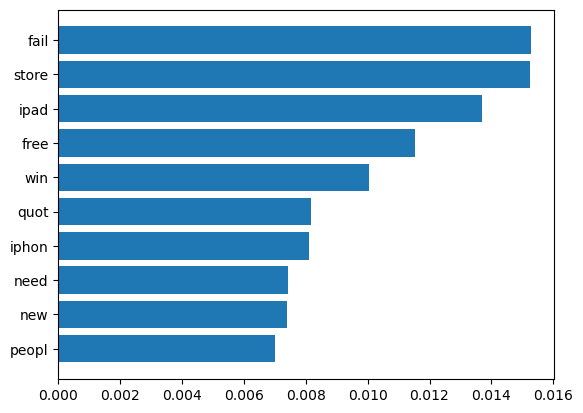

In [66]:
# preprocessing
feats = [x[0] for x in sorted(rf_vectorizer.vocabulary_.items(), key = lambda x: x[1])]
feat_importances = rf.feature_importances_
feature_importances = dict(zip(feats, feat_importances))

# get top 10
top_10_feats = [x[0] for x in sorted(feature_importances.items(), key = lambda x: x[1], reverse=True)][:10]
top_10_importances = [feature_importances[feat] for feat in top_10_feats]

# reverse, so that most important feature appears at top of horizontal bar chart
top_10_feats.reverse()
top_10_importances.reverse()

# plot
fig, ax = plt.subplots()

plt.barh(top_10_feats, top_10_importances);

**Utilizing the Model: Identifying Most Negative and Positive Tweets**

The primary purpose of building a classifier is to classify the "most negative" and "most positive" tweets using the model's pseudo-probability of a tweet being negative (or positive) as a "rating" of *how* negative (or positive) the tweet presumably is.

**Most Negative Tweets**

First, determine how many tweets in the training data are categorized as "100% negative" by the model. (Technically, this is not a proper interpretation of the pseudo-probability, but we hope, if the model is sufficiently good at classification, that the model's confidence in a tweet being negative might correspond to a particularly strong negative emotion in the tweet.)

In [50]:
np.sum(rf.predict_proba(X_train_vectorized)[:, 0] == 1)

20

Second, make a list of predicted probabilities that each tweet in the training data is negative, and select the first five tweets with the highest probability of being negative.

In [53]:
probability_negative = list(rf.predict_proba(X_train_vectorized)[:, 0])

top_5_most_negative_tweets = []

for i in range(5):
    most_negative_iloc = np.argmax(probability_negative)
    true_index = full_X_train.index[most_negative_iloc]
    
    top_5_most_negative_tweets.append(data.loc[true_index, 'tweet_text'])
    
    probability_negative.pop(most_negative_iloc)

Third, print and observe the tweets.

In [54]:
for tweet in top_5_most_negative_tweets:
    print(tweet)

#SXSW 2011: Novelty of iPad news apps fades fast among digital delegates {link}
Two iPad observations at #sxsw. Vast majority of people using them. Seen lots of 2s today. Looks nice. #appletakingoverworld
Apple is opening up a temporary store just for the #sxsw conference and the iPad 2 launch. Might have to make a stop.
#Circles set to fail for being too complicated by June. RT @mention Google set to launch new social network #Circles today at #sxsw
#sxsw  thanks for the ever present iPhone barging tables...


The first, last and second-to-last tweets do appear to be negative. However, the second and third tweets are not negative at all, calling into question the premise that we can use the predicted probability from this model as a "score" of negativity.

**Most Positive Tweets**

Repeat the above steps for positive tweets.

How many tweets in the training data does the model have 100% confidence in as being positive?

In [49]:
np.sum(rf.predict_proba(X_train_vectorized)[:, 1] == 1)

91

Select the first five tweets in the training data that have the highest predicted probability of being positive.

In [55]:
probability_positive = list(rf.predict_proba(X_train_vectorized)[:, 1])

top_5_most_positive_tweets = []

for i in range(5):
    most_positive_iloc = np.argmax(probability_positive)
    true_index = full_X_train.index[most_positive_iloc]
    
    top_5_most_positive_tweets.append(data.loc[true_index, 'tweet_text'])
    
    probability_positive.pop(most_positive_iloc)

Print and observe the "most positive" tweets.

In [56]:
for tweet in top_5_most_positive_tweets:
    print(tweet)

RT @mention RT @mention It's not a rumor: Apple is opening up a temporary store in downtown Austin for #SXSW + #iPad2 launch {link}
RT @mention Which smartphone rules #sxsw?  Definitely the iPhone 4.  96% of Apple smartphone I've eyeballed are the iP4
RT @mention Google's Marissa Mayer on the location-based 'fast, fun and future' {link} #SXSW #SXSWi
Farmers prefer Balckberries over iPhones and Andriod devices. More durable? Anti-Apple feelings?  #mobilefarm #sxsw
iPhone battery is going quickly. Guy behind me let me borrow his portable charger. I want one! {link} #SXSW


I don't feel confident that I can use the model as intended to rate the "most positive" and "most negative" tweets based on the predicted probability.

## Recommendations

Using the model to "rate" the most positive and most negative tweets is not actionable.

However, the results of data analysis suggest that...

- hosting another pop-up store at next year's conference would be well-received as it was this year, and

- timing the release of a new product, if possible, to launch during SXSW next year will help Apple to capture a lot of the buzz around the conference, as it did this year with the iPad 2.

## Conclusion

Recall the class distribution in the dataset:

In [59]:
data.sentiment.loc[data.sentiment.isin(['Positive emotion', 'Negative emotion'])].value_counts(normalize=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/algorithms.py:525: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


sentiment
Positive emotion    0.839346
Negative emotion    0.160654
Name: proportion, dtype: float64

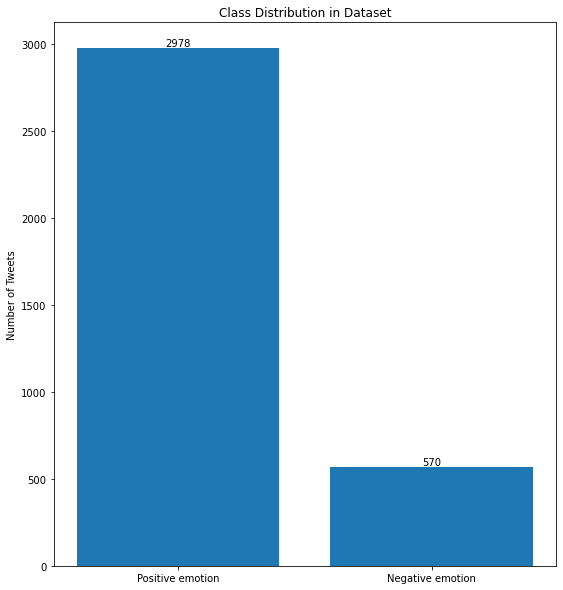

In [24]:
fig, ax = plt.subplots(figsize=(9, 10))

# create bar chart, and save bar container to "bars"
labels = data.sentiment.loc[data.sentiment.isin(['Positive emotion', 'Negative emotion'])].value_counts().index
values = data.sentiment.loc[data.sentiment.isin(['Positive emotion', 'Negative emotion'])].value_counts().values
bars = ax.bar(labels, values)

# orient x labels horizontally
for label in ax.get_xticklabels():
    label.set_rotation(0)

# label y-axis and un-label x-axis
ax.set_ylabel('Number of Tweets')
ax.set_xlabel('')

# title graph
ax.set_title('Class Distribution in Dataset')

# label each bar with number of tweets
ax.bar_label(bars)

# save figure to jpeg file
fig.savefig('images/class_dist.jpg', bbox_inches='tight');

The best model achieved a 60% recall of negative tweets and 89% recall of positive tweets, with an overall balanced accuracy of ~74% on the hold out test set.

Worryingly, the model achieves an accuracy of ~84% which is approximately equal to that of a "naive classifier" which always predicts the majority class.

When looking for the most positive and most negative tweets in the dataset based on the model's confidence score, we ran into two issues:

1.) The model is 100% confident that 20 tweets are negative and 91 tweets are positive, so the "top 5" most negative or positive tweets are somewhat randomly selected from these.

2.) On inspection, the tweets for which the model is *most confident* in its predictions are not necessarily correctly classified by the model. Thus, the idea of using the model to determine the most positive and most negative tweets in the dataset is called into question.

## Next Steps

- Build two new classifiers which focus respectively on optimizing precision for the negative class and precision in predicting the positive class.

*The best classifier we had found prior to resampling actually seemed (on inspection) to provide more valuable insight into the "top 5 most negative tweets" despite doing a poorer job of recalling negative tweets. This suggests that if we build a classifier which focuses on **precision** in predicting the negative class, we might be able to gain insight into the most negative tweets in the dataset, and if we then build a classifier which focuses on precision in predicting the positive class, we could do the same for the most positive tweets in the dataset.*